# Example: Static inverse free-boundary equilibrium calculations (in ITER)

---

Here we will generate an equilibrium (find coil currents with the inverse solver) in an ITER-like tokamak. 

The machine description comes from files located [here](https://github.com/ProjectTorreyPines/FUSE.jl).

The equilbirium\profile parameters are **completely made up** - please experiment on your own and change them to more realistic values as you please!

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### Create the machine object

In [2]:
# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/ITER/ITER_active_coils.pickle",
    passive_coils_path=f"../machine_configs/ITER/ITER_passive_coils.pickle",
    limiter_path=f"../machine_configs/ITER/ITER_limiter.pickle",
    wall_path=f"../machine_configs/ITER/ITER_wall.pickle",
)

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.


Text(60.291666666666664, 0.5, 'Height, $Z$ [m]')

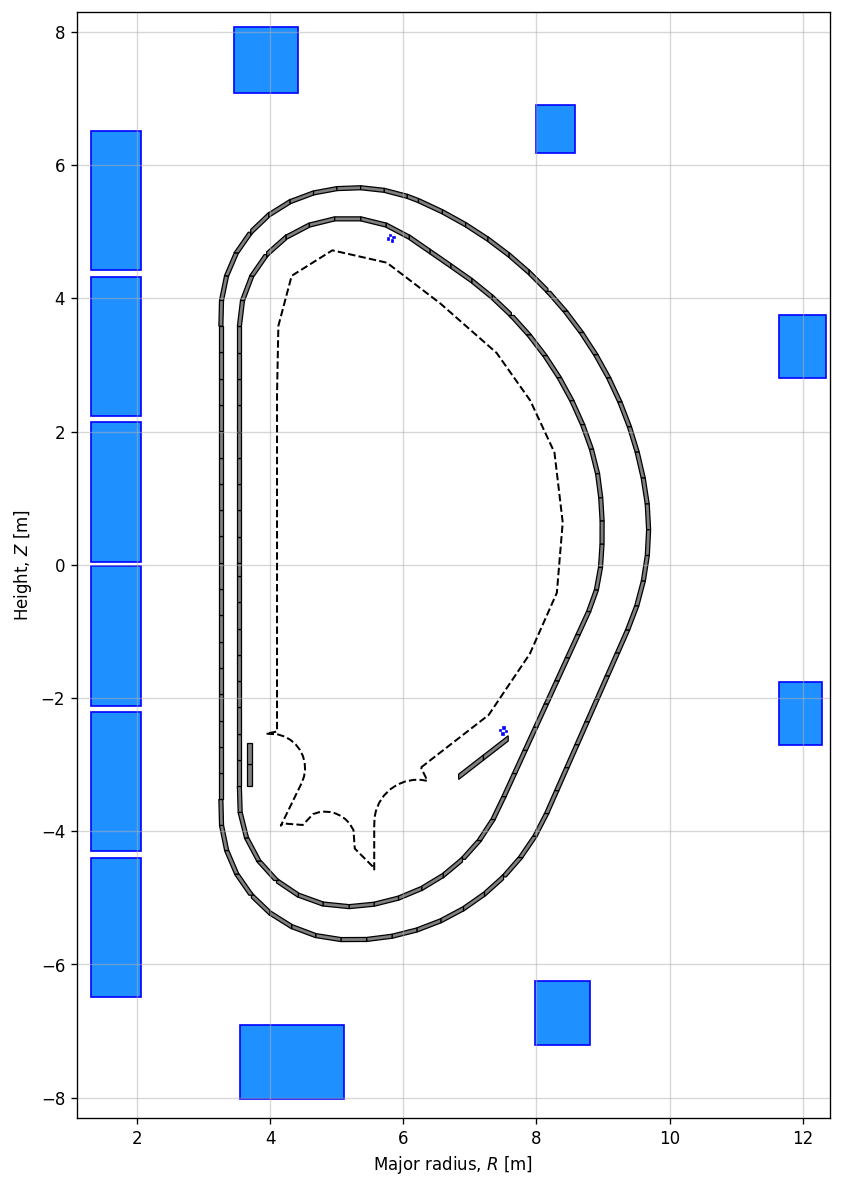

In [3]:
# plot the machine
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=120)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
# ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(1.1, 12.4)
ax1.set_ylim(-8.3, 8.3)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

### Instantiate an equilibrium

In [4]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,       # provide tokamak object
    Rmin=3.2, Rmax=8.8,   # radial range
    Zmin=-5, Zmax=5,   # vertical range
    nx=129,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,                # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

In [5]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainBetapIp
profiles = ConstrainBetapIp(
    eq=eq,        # equilibrium object
    betap=0.15,   # poloidal beta
    Ip=11e6,      # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=2.0,  # profile function parameter
    alpha_n=1.0   # profile function parameter
)

### Load the static nonlinear solver

In [6]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

In [7]:
Rx = 5.13      # X-point radius
Zx = -3.16      # X-point height

# set desired null_points locations
# this can include X-point and O-point locations
null_points = [[Rx], [Zx]]

# set desired isoflux constraints with format 
# isoflux_set = [isoflux_0, isoflux_1 ... ] 
# with each isoflux_i = [R_coords, Z_coords]
isoflux_set = np.array([[[Rx, 4.22, 4.35, 7.26, 7.91, 8.14, 7.47, 6.05, 4.85, 4.28, 5.4, 4.3], [Zx, 0.55, -1.45, -1.94, -0.77, 0.55, 2.55, 3.74, 3.78, 2.50, -4.5, -3.9]]])
           

# instantiate the freegsnke constrain object
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)


# remove from the coils available for control the radial field coil 
# eq.tokamak['VS3'].control = False


### The inverse solve

In [8]:
GSStaticSolver.inverse_solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-5,
                     target_relative_psit_update=1e-3,
                     max_iter_per_update=10,
                     max_rel_update_size=0.075,
                     damping_factor=.99,
                     max_rel_psit=.05,
                     verbose=True, # print output
                     l2_reg=1e-14,
                     )


-----
Inverse static solve starting...
Initial guess for plasma_psi successful, residual found.
Initial relative error = 2.46e+01
-----
Iteration: 0
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['2.22e+07', '2.22e+07', '2.79e+07', '1.13e+04', '6.80e+06', '7.29e+05', '5.20e+05', '5.65e+05', '1.41e+05', '6.81e+06']
Constraint losses = 4.52e-01
Relative update of tokamak psi (in plasma core): 2.37e+09
Handing off to forward solve (with updated currents).
-----
Iteration: 1
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['1.47e+07', '1.42e+07', '1.89e+07', '5.93e+02', '3.90e+06', '7.79e+05', '1.15e+05', '1.80e+05', '7.57e+05', '3.39e+06']
Constraint losses = 1.04e+00
Relative update of tokamak psi (in plasma core): 3.15e-01
Handing off to forward solve (with updated currents).
-----
Iteration: 2
Using simpl

/Users/kpentlan/Documents/Projects/Software/freegs4e/freegs4e/jtor.py:361: RuntimeWarning: divide by zero encountered in scalar divide
  L = self.Ip / I_R - LBeta0 * (IR / I_R - 1)
/Users/kpentlan/Documents/Projects/Software/freegs4e/freegs4e/jtor.py:361: RuntimeWarning: invalid value encountered in scalar divide
  L = self.Ip / I_R - LBeta0 * (IR / I_R - 1)


In [ ]:
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 15), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax1,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax1, show=False)                                                          # plots the contraints
ax1.set_xlim(1.1, 12.4)
ax1.set_ylim(-8.3, 8.3)

In [ ]:
eq.tokamak.getCurrents()

# # save coil currents to file
# import pickle
# with open('simple_diverted_currents_PaxisIp.pk', 'wb') as f:
#     pickle.dump(obj=inverse_current_values, file=f)

{'CS1': -916240169.5031351,
 'CS2': -878874629.9237533,
 'CS3': -1154706427.123091,
 'VS3': 0.0,
 'PF1': -245654120.6336851,
 'PF2': -44564685.45594211,
 'PF3': -18121815.069925826,
 'PF4': -24208208.814537957,
 'PF5': -39078064.866639405,
 'PF6': -213816104.26669168,
 'I1_0': 0.0,
 'I2_0': 0.0,
 'I3_0': 0.0,
 'I4_0': 0.0,
 'I5_0': 0.0,
 'I6_0': 0.0,
 'I7_0': 0.0,
 'I8_0': 0.0,
 'I9_0': 0.0,
 'I10_0': 0.0,
 'I11_0': 0.0,
 'I12_0': 0.0,
 'I13_0': 0.0,
 'I14_0': 0.0,
 'I15_0': 0.0,
 'I16_0': 0.0,
 'I17_0': 0.0,
 'I18_0': 0.0,
 'I19_0': 0.0,
 'I20_0': 0.0,
 'I21_0': 0.0,
 'I22_0': 0.0,
 'I23_0': 0.0,
 'I24_0': 0.0,
 'I25_0': 0.0,
 'I26_0': 0.0,
 'I27_0': 0.0,
 'I28_0': 0.0,
 'I29_0': 0.0,
 'I30_0': 0.0,
 'I31_0': 0.0,
 'I32_0': 0.0,
 'I33_0': 0.0,
 'I34_0': 0.0,
 'I35_0': 0.0,
 'I36_0': 0.0,
 'I37_0': 0.0,
 'I38_0': 0.0,
 'I39_0': 0.0,
 'I40_0': 0.0,
 'I41_0': 0.0,
 'I42_0': 0.0,
 'I43_0': 0.0,
 'I44_0': 0.0,
 'I45_0': 0.0,
 'I46_0': 0.0,
 'I47_0': 0.0,
 'I48_0': 0.0,
 'I49_0': 0.0,
 'I50